In [2]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
import tensorflow.contrib.eager as tfe
from functools import partial
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib.tri as tri
from scipy import stats
from scipy.special import gamma as gamma_fun
import scipy.special as spec
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import numpy as np
import sklearn.preprocessing 


from deep_bayes.models import DeepEvidentialModel
from deep_bayes.settings import EVIDENTIAL_DEFAULTS
from deep_bayes.training import train_online
from deep_bayes.losses import bayes_risk, regularized_bayes_risk
from deep_bayes.viz import plot_model_samples, plot_confusion_matrix
from deep_bayes.diagnostics import accuracy

from sklearn import metrics## ignore warnings
import warnings
warnings.filterwarnings("ignore")

/Users/liangela/opt/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/liangela/opt/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/liangela/opt/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/liangela/opt/anaconda3/e

In [4]:
from sklearn import metrics## ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
tf.enable_eager_execution()

In [7]:
%matplotlib inline

In [8]:
from sklearn import metrics## ignore warnings
import warnings
warnings.filterwarnings("ignore")

#  Generative model specifications

## Model prior 
<p>Defines the prior probabilities over models $p(\boldsymbol{m})$.</p>

In [9]:
def model_prior(batch_size, n_models, p_vals=None):
    """
    Samples from the models' prior batch size times and converts to one-hot.
    Assumes equal model priors.
    ----------
    
    Arguments:
    batch_size : int  -- the number of samples to draw from the prior
    n_models   : int  -- the number of generative models in queston
    ----------
    
    Returns:
    m_true : np.ndarray of shape (batch_size, theta_dim) -- the samples batch of parameters
    """
    
    # Equal priors, if nothign specified
    if p_vals is None:
        p_vals = [1/n_models] * n_models
    m_idx = np.random.choice(n_models, size=batch_size, p=p_vals).astype(np.int32)
    return m_idx

## Model parameters priors
<p>Defines how parameters are generated given a model $p(\boldsymbol{\theta}|\boldsymbol{m})$.</p>

In [10]:
from scipy.stats import truncnorm
from scipy.stats import invgamma
def factor_model1_prior(**args):
    """
    Samples from the prior of the first model.
    ----------
    
    Arguments:
    ----------
    
    Output:
    theta : np.ndarray of shape (1, theta_dim) -- the samples of parameters
    """
    
    theta1 = truncnorm.rvs(0, 1, size=3) #truncated normal prior for the diagonals of lambda
    theta2 = np.random.normal(loc=0., scale=1.,size = (10,3)) # (matrix) of normal prior 
    theta3 = invgamma.rvs(0.5, loc=0, scale=0.5,size=10) # inverse gamma prior distribution for diagonal elements of Sigma
    
    Sigma = np.diag(theta3)#Sigma （ a 10*10 diagonal matrix)
    Lambda = np.tril(theta2)# normal prior for the lower triangular elements of Lambda
    Lambda[:,1] = np.zeros(10)
    Lambda[:,2] = np.zeros(10) # we get 1-factor model lambda
    
    theta = (Sigma,Lambda)
    return theta

from scipy.stats import invgamma
def factor_model2_prior(**args):
    """
    Samples from the prior of the second model.
    ----------
    
    Arguments:
    ----------
    
    Output:
    theta : np.ndarray of shape (1, theta_dim) -- the samples of parameters
    """
    theta1 = truncnorm.rvs(0, 1, size=3) #truncated normal prior for the diagonals of lambda
    theta2 = np.random.normal(loc=0., scale=1.,size = (10,3)) # (matrix) of normal prior 
    theta3 = invgamma.rvs(0.5, loc=0, scale=0.5,size=10) # inverse gamma prior distribution for diagonal elements of Sigma
    
    Sigma = np.diag(theta3)#Sigma （ a 10*10 diagonal matrix)
    Lambda = np.tril(theta2)# normal prior for the lower triangular elements of Lambda
    Lambda[:,2] = np.zeros(10) # we get 2-factor model lambda
    
    theta = (Sigma,Lambda)    
    return theta

def factor_model3_prior(**args):
    """
    Samples from the prior of the second model.
    ----------
    
    Arguments:
    ----------
    
    Output:
    theta : np.ndarray of shape (1, theta_dim) -- the samples of parameters
    """
    theta1 = truncnorm.rvs(0, 1, size=3) #truncated normal prior for the diagonals of lambda
    theta2 = np.random.normal(loc=0., scale=1.,size = (10,3)) # (matrix) of normal prior 
    theta3 = invgamma.rvs(0.5, loc=0, scale=0.5,size=10) # inverse gamma prior distribution for diagonal elements of Sigma
    
    Sigma = np.diag(theta3)#Sigma（a 10*10 diagonal matrix)
    Lambda = np.tril(theta2)# normal prior for the lower triangular elements of Lambda / 3-factor model lambda
    
    theta = (Sigma,Lambda)    
    return theta    


## Generative models
<p>Defines how the data are generated, that is, $\boldsymbol{x}_{1:N} \sim p(\boldsymbol{x}|boldsymbol{\theta},\boldsymbol{m}).$

In [11]:
p=10 # number of outcomes
n=100 # sample size
k=3 # number of factors
m=4 # simulate m samples

def factor_model1(params, n_obs, **args):
    """
    Runs the forward model once, i.e., generates a sample from p(x|theta, m).
    ----------
    
    Arguments:
    params : np.ndarray of shape (theta_dim, ) -- the data generating parameters
    n_obs  : int -- the numebr of observations to draw from p(x|theta)
    ----------
    
    Output:
    x      : np.ndarray of shape (n_obs, x_dim)
    """
    Omega = np.dot(params[1],np.transpose(params[1]))+params[0]# Omega
    mu = np.zeros(10)# True mean 
    x = sklearn.preprocessing.normalize(np.random.multivariate_normal(mean = mu, cov = Omega, size = n_obs))
    return x


def factor_model2(params, n_obs, **args):
    """
    Runs the forward model once, i.e., generates a sample from p(x|theta, m).
    ----------
    
    Arguments:
    params : np.ndarray of shape (theta_dim, ) -- the data generating parameters
    n_obs  : int -- the numebr of observations to draw from p(x|theta)
    ----------
    
    Output:
    x      : np.ndarray of shape (n_obs, x_dim)
    """
    
    Omega = np.dot(params[1],np.transpose(params[1]))+params[0]# Omega
    mu = np.zeros(10)# True mean 
    x = sklearn.preprocessing.normalize(np.random.multivariate_normal(mean = mu, cov = Omega, size = n_obs))
    return x


def factor_model3(params, n_obs, **args):
    """
    Runs the forward model once, i.e., generates a sample from p(x|theta, m).
    ----------
    
    Arguments:
    params : np.ndarray of shape (theta_dim, ) -- the data generating parameters
    n_obs  : int -- the numebr of observations to draw from p(x|theta)
    ----------
    
    Output:
    x      : np.ndarray of shape (n_obs, x_dim)
    """
    
    Omega = np.dot(params[1],np.transpose(params[1]))+params[0]# Omega
    mu = np.zeros(10)# True mean 
    x = sklearn.preprocessing.normalize(np.random.multivariate_normal(mean = mu, cov = Omega, size = n_obs))
    return x

## Data generator
<p>Define the algorithm:</p>
1. <strong>for</strong> $i = 1,...,B$<br>
2. &emsp;$\boldsymbol{m}^{(i)} \sim p(\boldsymbol{m})$<br>
3. &emsp;$\boldsymbol{\theta}^{(i)} \sim p(\boldsymbol{\theta}|\boldsymbol{m}^{(i)})$<br>
4. &emsp;$\boldsymbol{x}_{1:N}^{(i)} \sim p(\boldsymbol{x}|\boldsymbol{\theta}^{(i)},\boldsymbol{m}^{(i)})$

In [15]:
def data_generator(batch_size, model_prior, param_priors, forward_models, 
                   n_obs=None, n_obs_min=100, n_obs_max=500, to_tensor=True, **args):
    """
    Runs the forward model 'batch_size' times by first sampling fromt the prior
    theta ~ p(theta) and running x ~ p(x|theta).
    ----------
    
    Arguments:
    batch_size     : int -- the number of samples to draw from the prior
    model_prior    : callable -- the prior which returns a sample of model indices
    param_priors   : list of callables -- a list with model prior samplers
    forward_models : list of generative models g(theta) -- a list of generatibve models
    n_obs          : int -- the numebr of observations to draw from p(x|theta)
    n_obs_min      : int -- used when n_obs is None, draws n_obs ~ U(n_obs_min, n_obs_max)
    n_obs_max      : int -- used when n_obs is None, draws n_obs ~ U(n_obs_min, n_obs_max)
    to_tensor      : boolean -- converts theta and x to tensors if True
    ----------
    
    Output:
    m     : tf.Tensor or np.ndarray of shape (batch_size, n_models) - the one-hot encoded version of the models
    theta : tf.Tensor or np.ndarray of shape (batch_size, theta_dim) - the data gen parameters 
    x     : tf.Tensor of np.ndarray of shape (batch_size, n_obs, x_dim)  - the generated data
    """
    
    # Sample from model prior
    # m_indices is an np.int32 array of model indices  
    n_models = len(forward_models)
    m_indices = model_prior(batch_size, n_models)
    
    # Sample N, if not specified
    if n_obs is None:
        n_obs = np.random.randint(low=n_obs_min, high=n_obs_max+1)
    
    # For each model index, sample from prior and run generative model.
    x = []
    theta = []
    for m_idx in m_indices:
        
        # Draw from model prior theta ~ p(theta|
        theta_m = param_priors[m_idx]()
        
        # Generate data from x = g_m(theta) <=> x ~ p(x|theta,m)
        x_m = forward_models[m_idx](theta_m, n_obs)
        
        # Store data and params
        x.append(x_m)
        theta.append(theta_m)
    
    # One-hot encode model indices
    m = to_categorical(m_indices, num_classes=n_models)
    
    # Convert to tensor, if specified 
    if to_tensor:
        #theta = tf.convert_to_tensor(theta, dtype=tf.float32)
        x = tf.convert_to_tensor(x, dtype=tf.float32)
        m = tf.convert_to_tensor(m, dtype=tf.float32)
    return {'m': m, 'x': x}

# Online training (unregularized, fixed N)

## Params

In [24]:
#--- Training hyperparameters ---#
ckpt_file = "factor_model_selection_fixed"
batch_size = 128
epochs = 5
iterations_per_epoch = 1000
n_obs = 100
n_test = 500


#--- Optimizer hyperparameters ---#
starter_learning_rate = 0.0005
global_step = tfe.Variable(0, dtype=tf.int32)
decay_steps = 1000
decay_rate = .99
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 
                                           decay_steps, decay_rate, staircase=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)


#--- Generative model hyperparameters ---#
model_names = ['Factor1','Factor2','Factor3']


param_priors = [factor_model1_prior, factor_model2_prior,factor_model3_prior]

forward_models = [factor_model1, factor_model2,factor_model3]

data_gen = partial(data_generator, 
                   model_prior=model_prior, 
                   param_priors=param_priors,
                   forward_models=forward_models,
                   n_obs=n_obs)

## creat test data

Here the test_data_min contains to values:

* m: the real value
* x: the input values

We want to plot real value and predicted value, so we should find the predicted value.

In [17]:
%%time
test_data_min = data_gen(n_test)

CPU times: user 363 ms, sys: 11.4 ms, total: 374 ms
Wall time: 381 ms


In [18]:
test_data_min['m'].shape

TensorShape([Dimension(500), Dimension(3)])

In [19]:
test_data_min['x'].shape

TensorShape([Dimension(500), Dimension(100), Dimension(10)])

## Create model

In [20]:
model_unreg_fixed = DeepEvidentialModel(EVIDENTIAL_DEFAULTS)

## Compile model
<p>In other words, run and plot performance of untrained networks.</p>

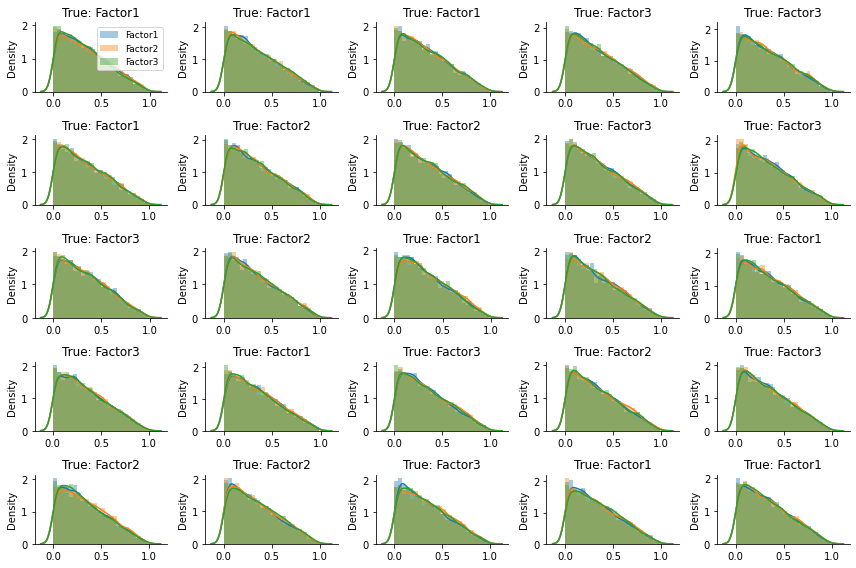

In [21]:
plot_model_samples(model_unreg_fixed, 
                       x_test=test_data_min['x'][:25], 
                       m_test=test_data_min['m'][:25], 
                       model_names=model_names,
                       figsize=(12, 8))

## Manage checkpoints

In [22]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model_unreg_fixed)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/{}'.format(ckpt_file), max_to_keep=2)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Restored from ./checkpoints/factor_model_selection_fixed/ckpt-10


## Train network

Training epoch 1:   0%|          | 0/1000 [00:00<?, ?it/s]

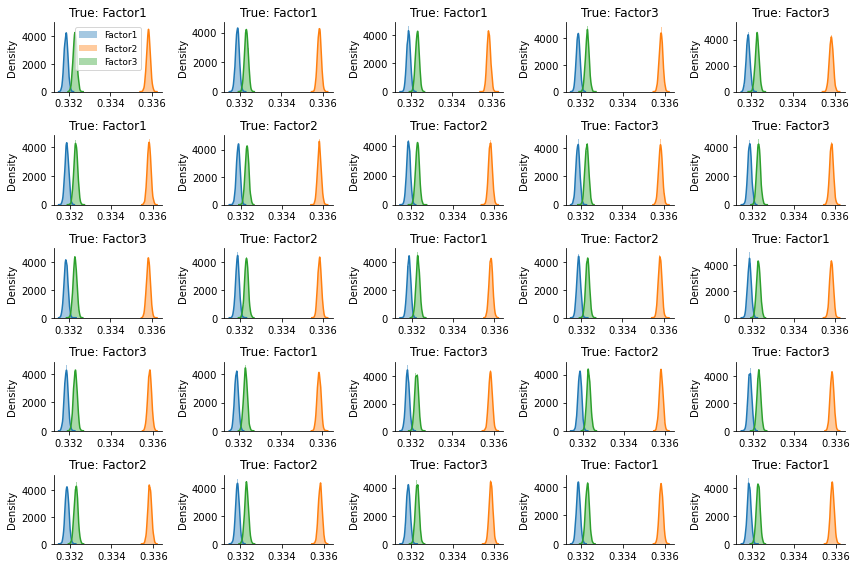

Training epoch 2:   0%|          | 0/1000 [00:00<?, ?it/s]

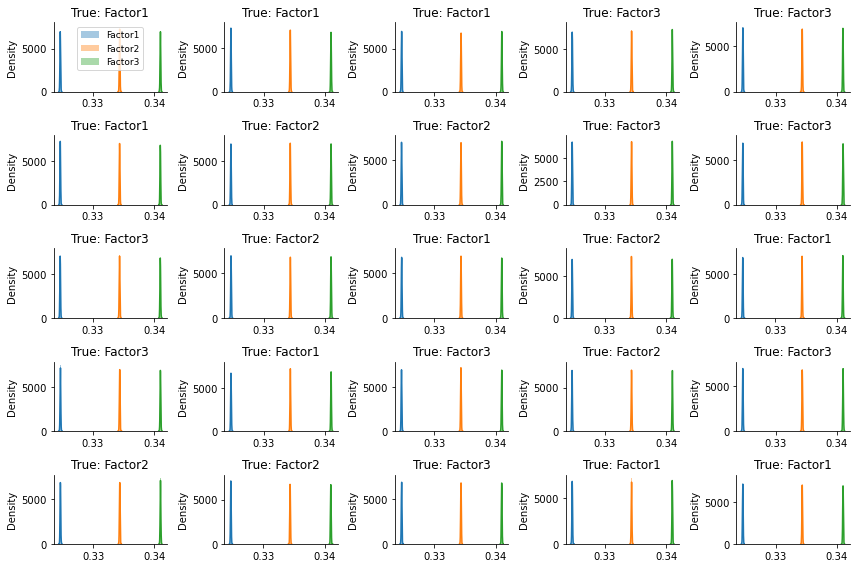

Training epoch 3:   0%|          | 0/1000 [00:00<?, ?it/s]

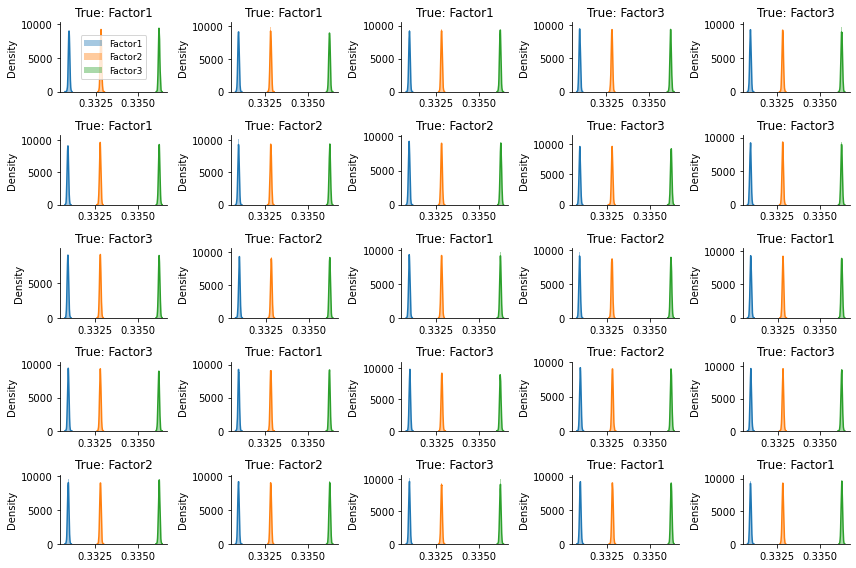

Training epoch 4:   0%|          | 0/1000 [00:00<?, ?it/s]

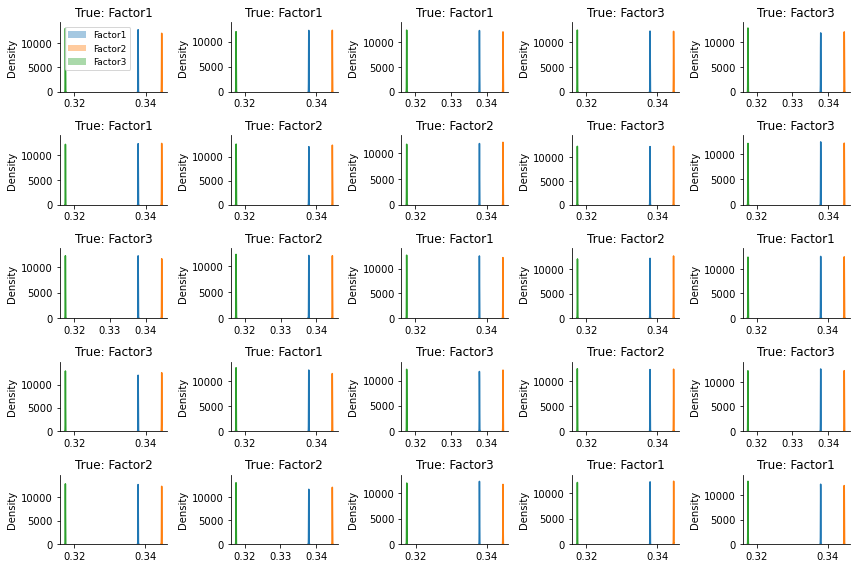

Training epoch 5:   0%|          | 0/1000 [00:00<?, ?it/s]

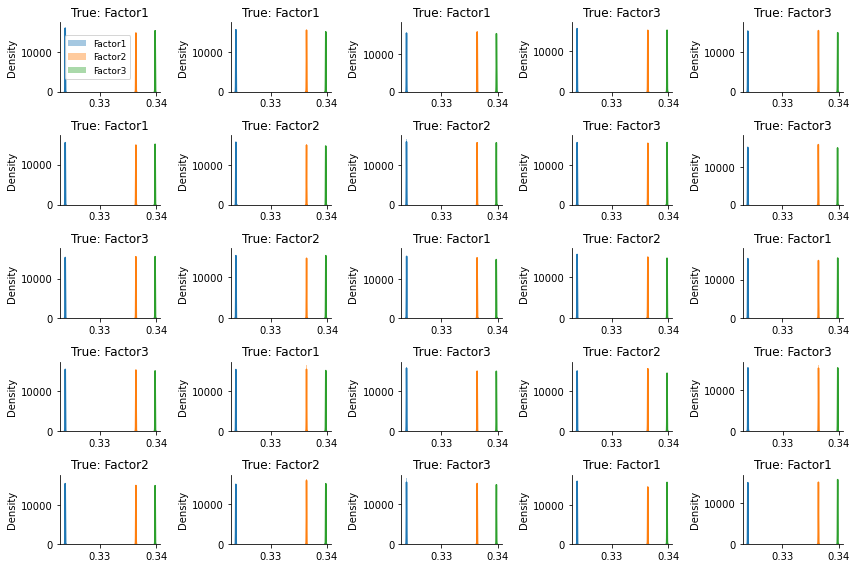

CPU times: user 1h 15min 54s, sys: 40.6 s, total: 1h 16min 35s
Wall time: 22min 55s


In [25]:
%%time
for ep in range(1, epochs+1):
     with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
         losses = train_online(model=model_unreg_fixed, 
                               optimizer=optimizer, 
                               data_gen=data_gen, 
                               loss_fun=bayes_risk, 
                               iterations=iterations_per_epoch,
                               batch_size=batch_size,
                               p_bar=p_bar,
                               global_step=global_step,
                               method='evidence')
        
         # Plot stuff
         plot_model_samples(model_unreg_fixed, 
                        x_test=test_data_min['x'][:25], 
                        m_test=test_data_min['m'][:25], 
                        model_names=model_names,
                        figsize=(12, 8))
         manager.save()

## Validate evidential network

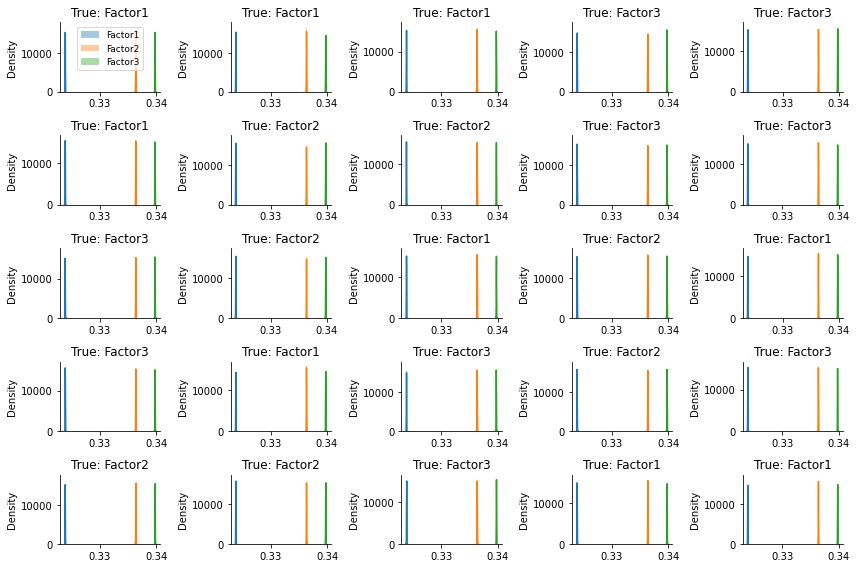

In [26]:
plot_model_samples(model_unreg_fixed, 
                       x_test=test_data_min['x'][:25], 
                       m_test=test_data_min['m'][:25], 
                       model_names=model_names,
                       figsize=(12, 8))

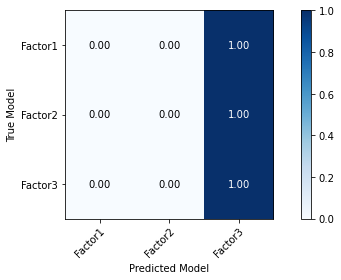

In [27]:
m_pred = model_unreg_fixed(test_data_min['x'])['m_probs']
plot_confusion_matrix(m_pred.numpy().argmax(axis=1), test_data_min['m'], model_names, figsize=(8,4),normalize=True)

In [28]:
m_pred = model_unreg_fixed(test_data_min['x'])['m_probs']
print(accuracy(test_data_min['m'], m_pred))

0.332


In [27]:
priors = ((1, 1), (30, 30))
bf = beta_binom(priors[1], test_data['x'].numpy()) / beta_binom(priors[0], test_data['x'].numpy())
# Bayes factors
m_probs = model_unreg_fixed(test_data_min['x'])['m_probs'].numpy()
bf_hat = m_probs[:, 1] / m_probs[:, 0]

f, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.scatter(bf, bf_hat)
ax.plot(ax.get_xlim(), ax.get_xlim(), '--', color='black')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel(r'True $BF_{10}$')
ax.set_ylabel('Estimated $BF_{10}$')
f.savefig('figures/BF_toy.png', dpi=300, bbox_inches='tight')

NameError: name 'beta_binom' is not defined